In [1]:
import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

You must install GPy (pip install GPy) to fit the GP regression nonlinearity.


Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [48]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [2]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells()
cells['bipolar'] = load_bipolar_cells()
cells['amacrine'] = load_amacrine_cells()
cells['horizontal'] = load_horizontal_cells()

In [52]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))

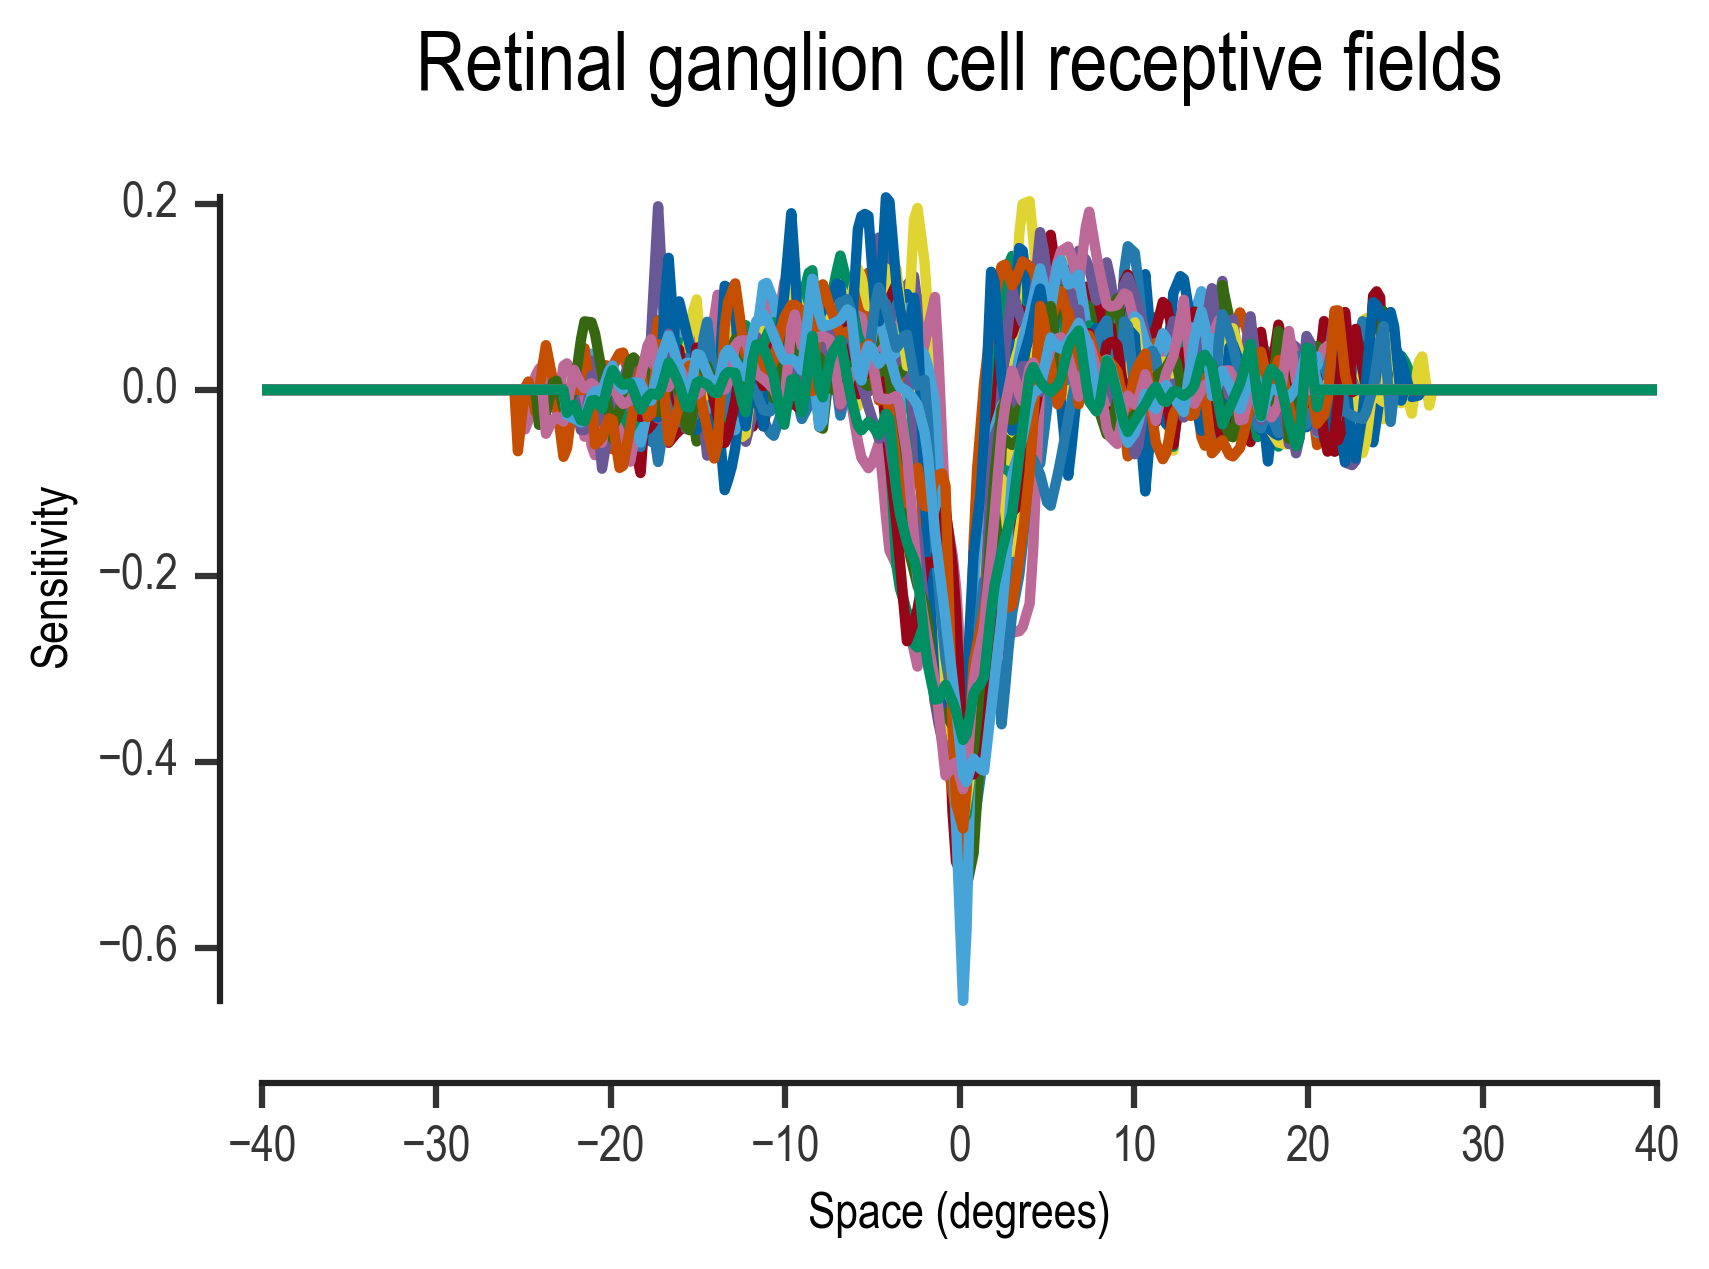

In [76]:
for c in receptive_fields['ganglion']:
    plt.plot(space, c)
plt.xlabel('Space (degrees)')
plt.ylabel('Sensitivity')
plt.title('Retinal ganglion cell receptive fields')
adjust_spines(plt.gca())

Average retinal ganglion cell receptive field

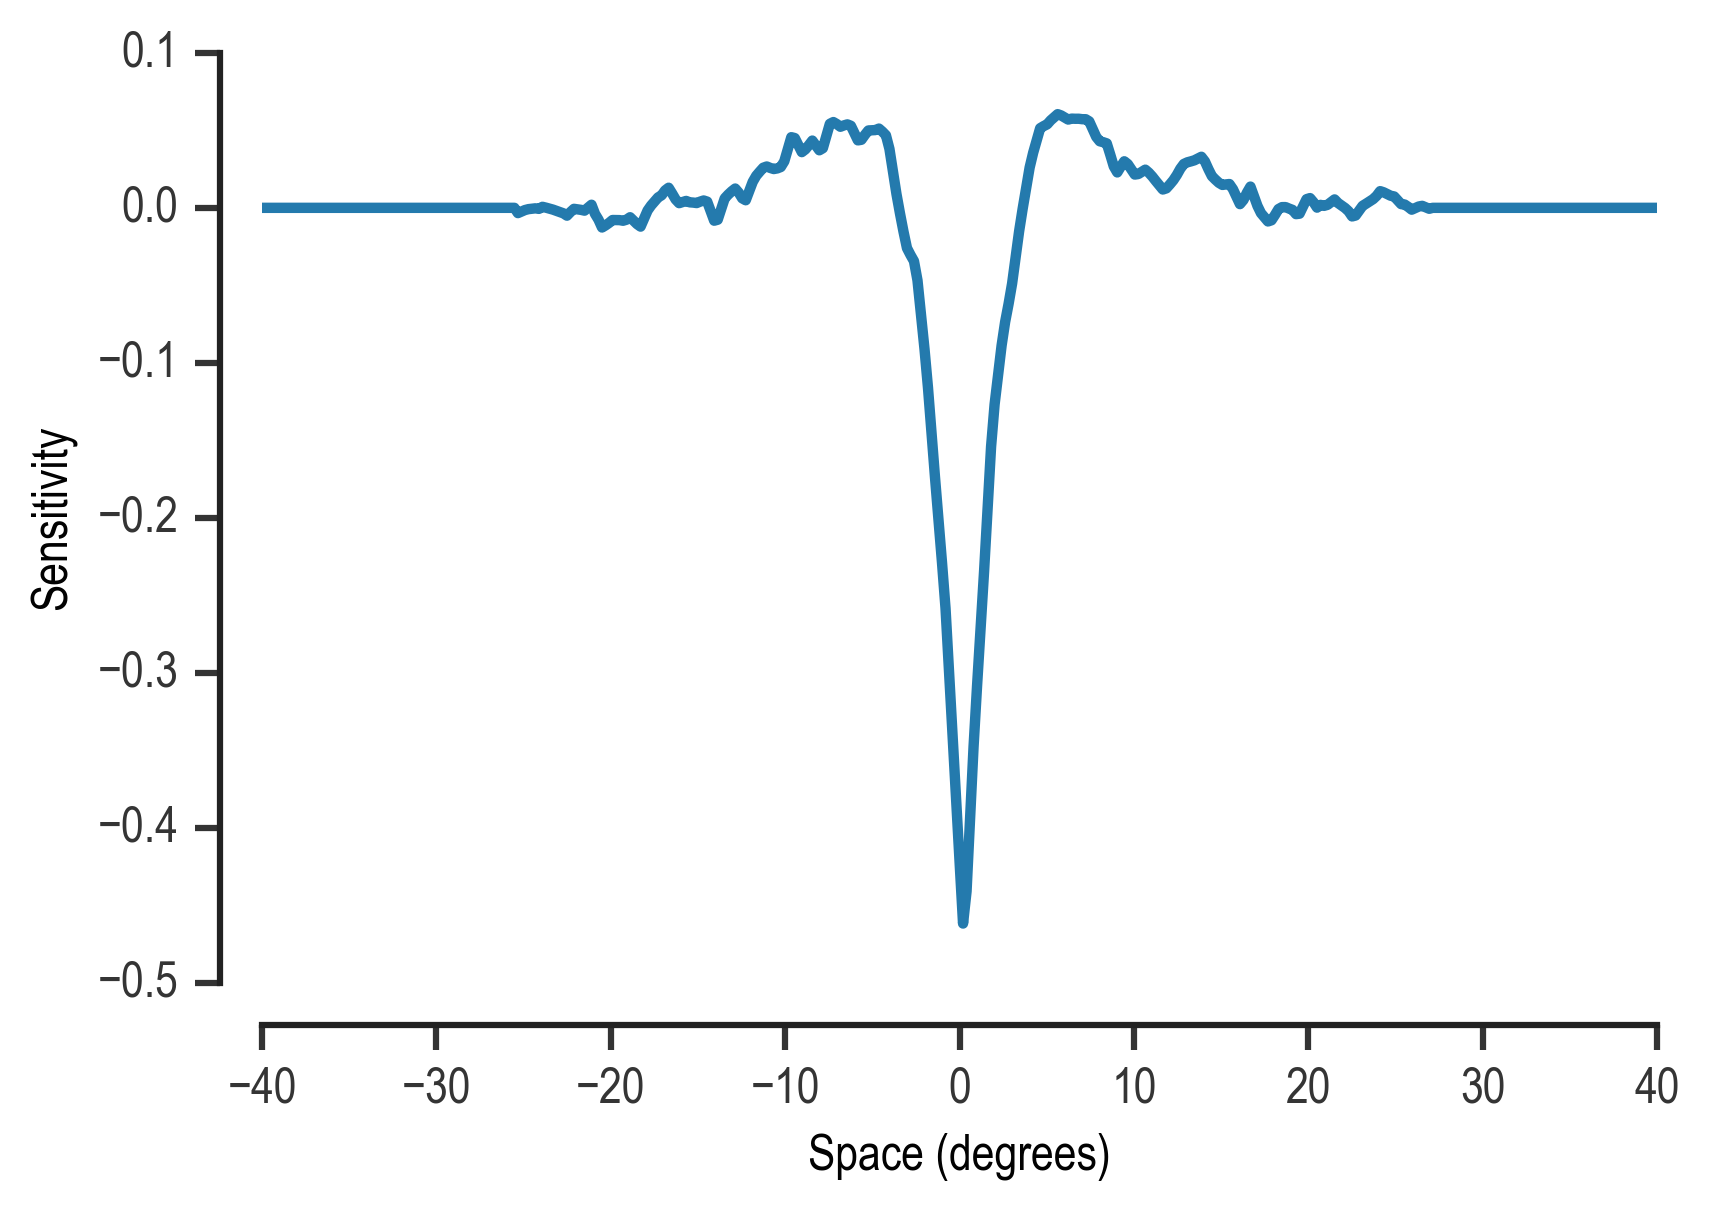

In [118]:
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)
plt.plot(space, average_ganglion_rf)
plt.ylabel('Sensitivity')
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

### Compute projective fields

In [242]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

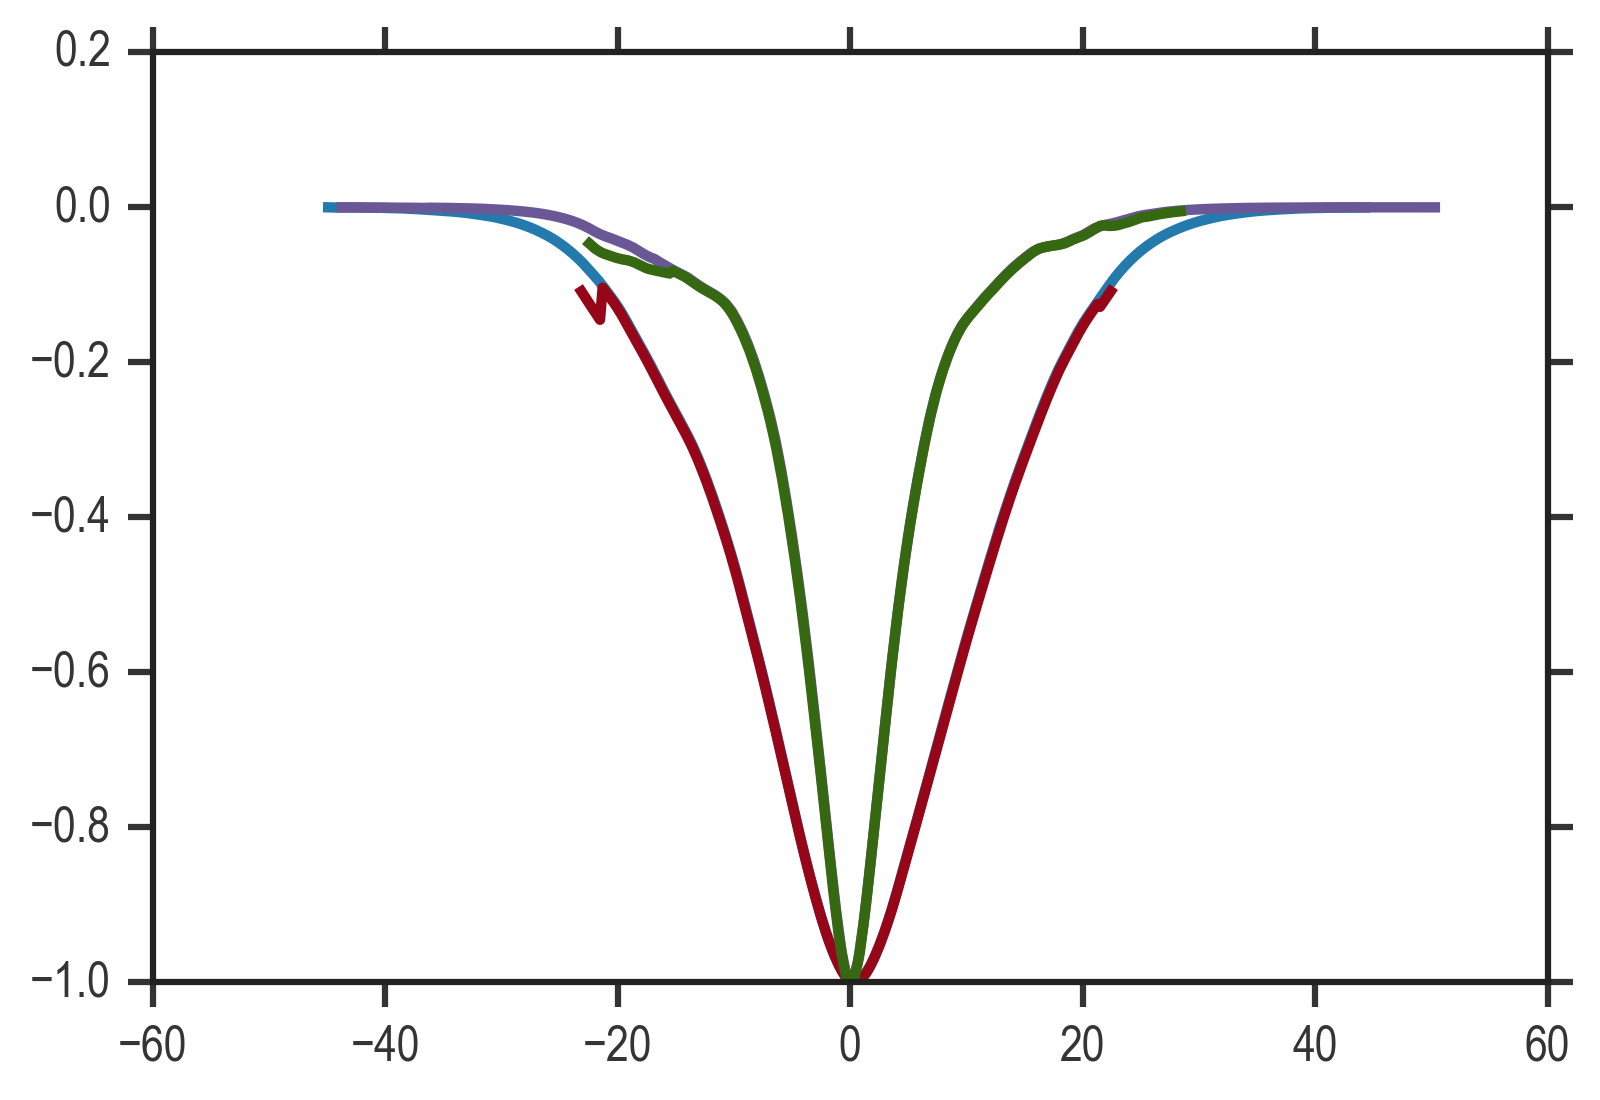

In [69]:
plt.plot(space_h_full, horz_pf_full/np.max(abs(horz_pf_full)))
plt.plot(space_h_same, horz_pf_same/np.max(abs(horz_pf_same)))
plt.plot(space_a_full, ama_pf_full/np.max(abs(ama_pf_full)))
plt.plot(space_a_same, ama_pf_same/np.max(abs(ama_pf_same)))

In [243]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

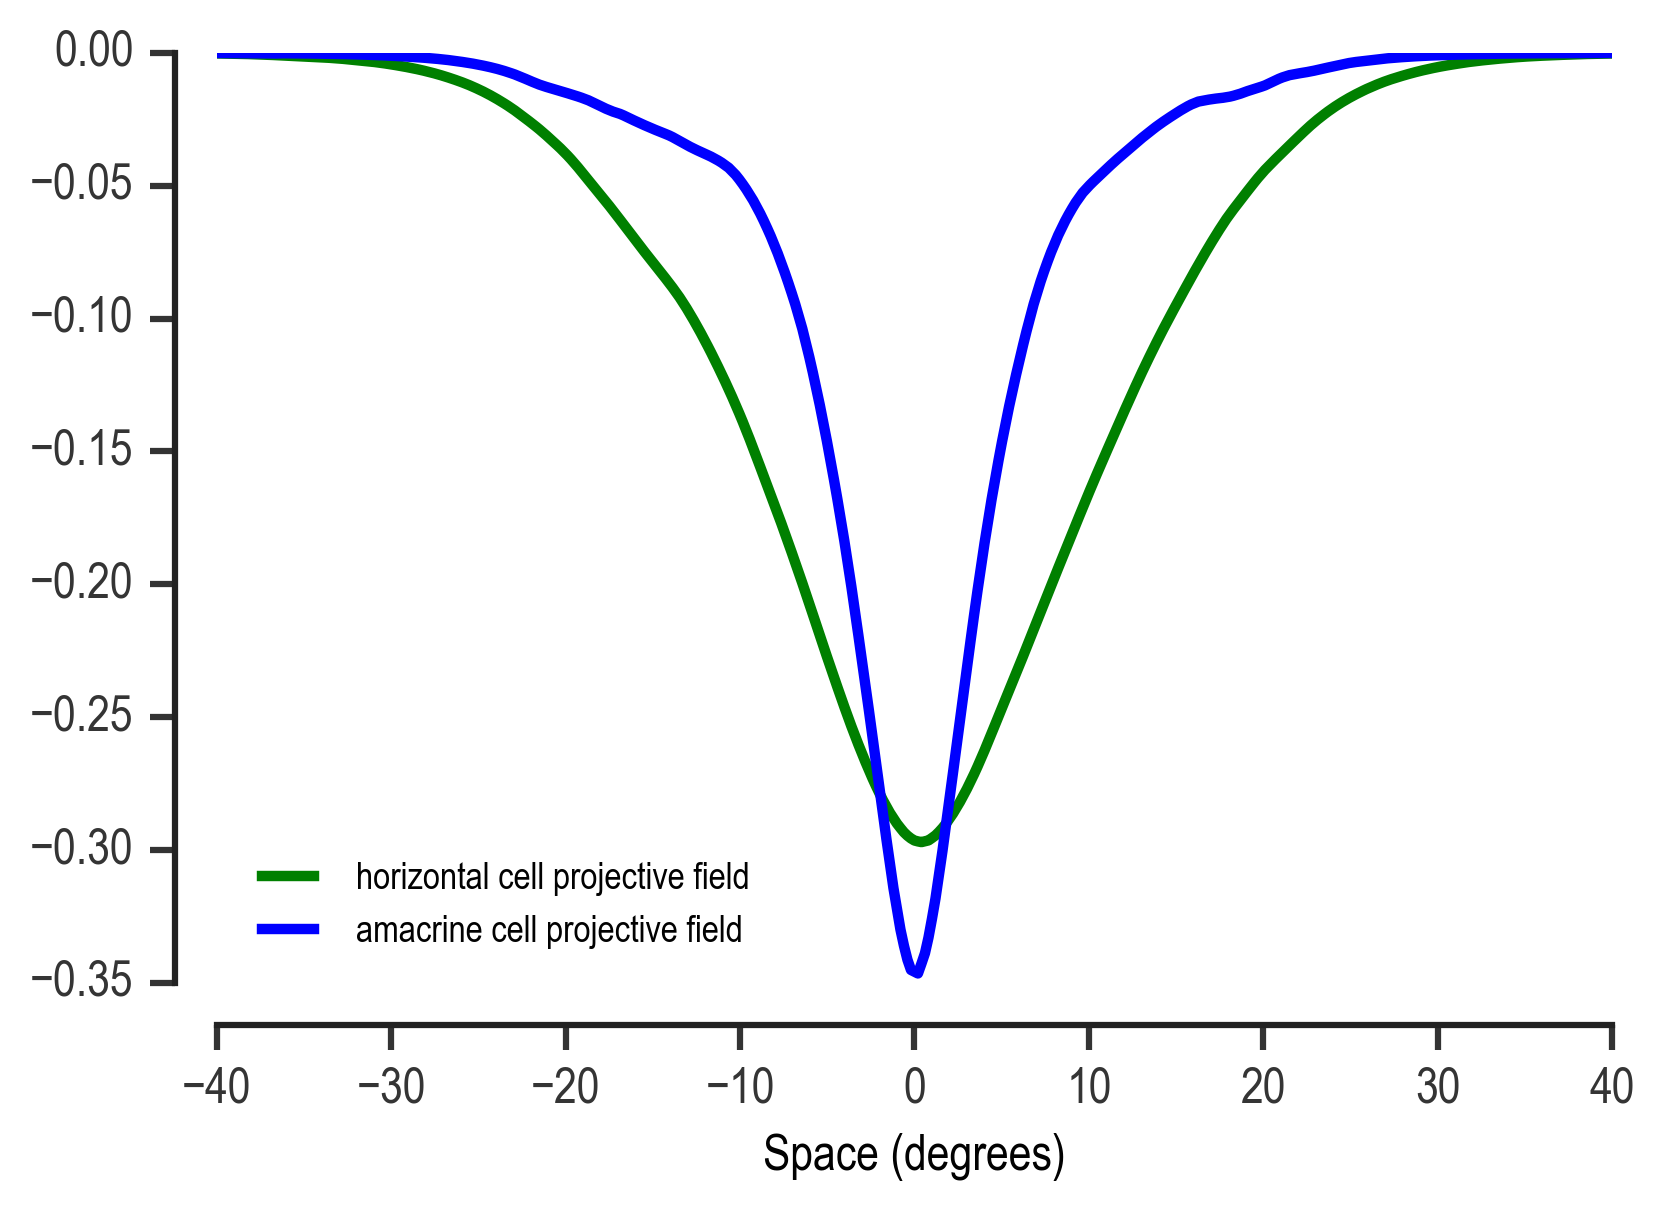

In [244]:
plt.plot(space, horz_pf, 'g', label='horizontal cell projective field')
plt.plot(space, ama_pf, 'b', label='amacrine cell projective field')
plt.legend(frameon=False, fontsize=9, loc='lower left')
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

### Signal

In [77]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd01A'
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [93]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


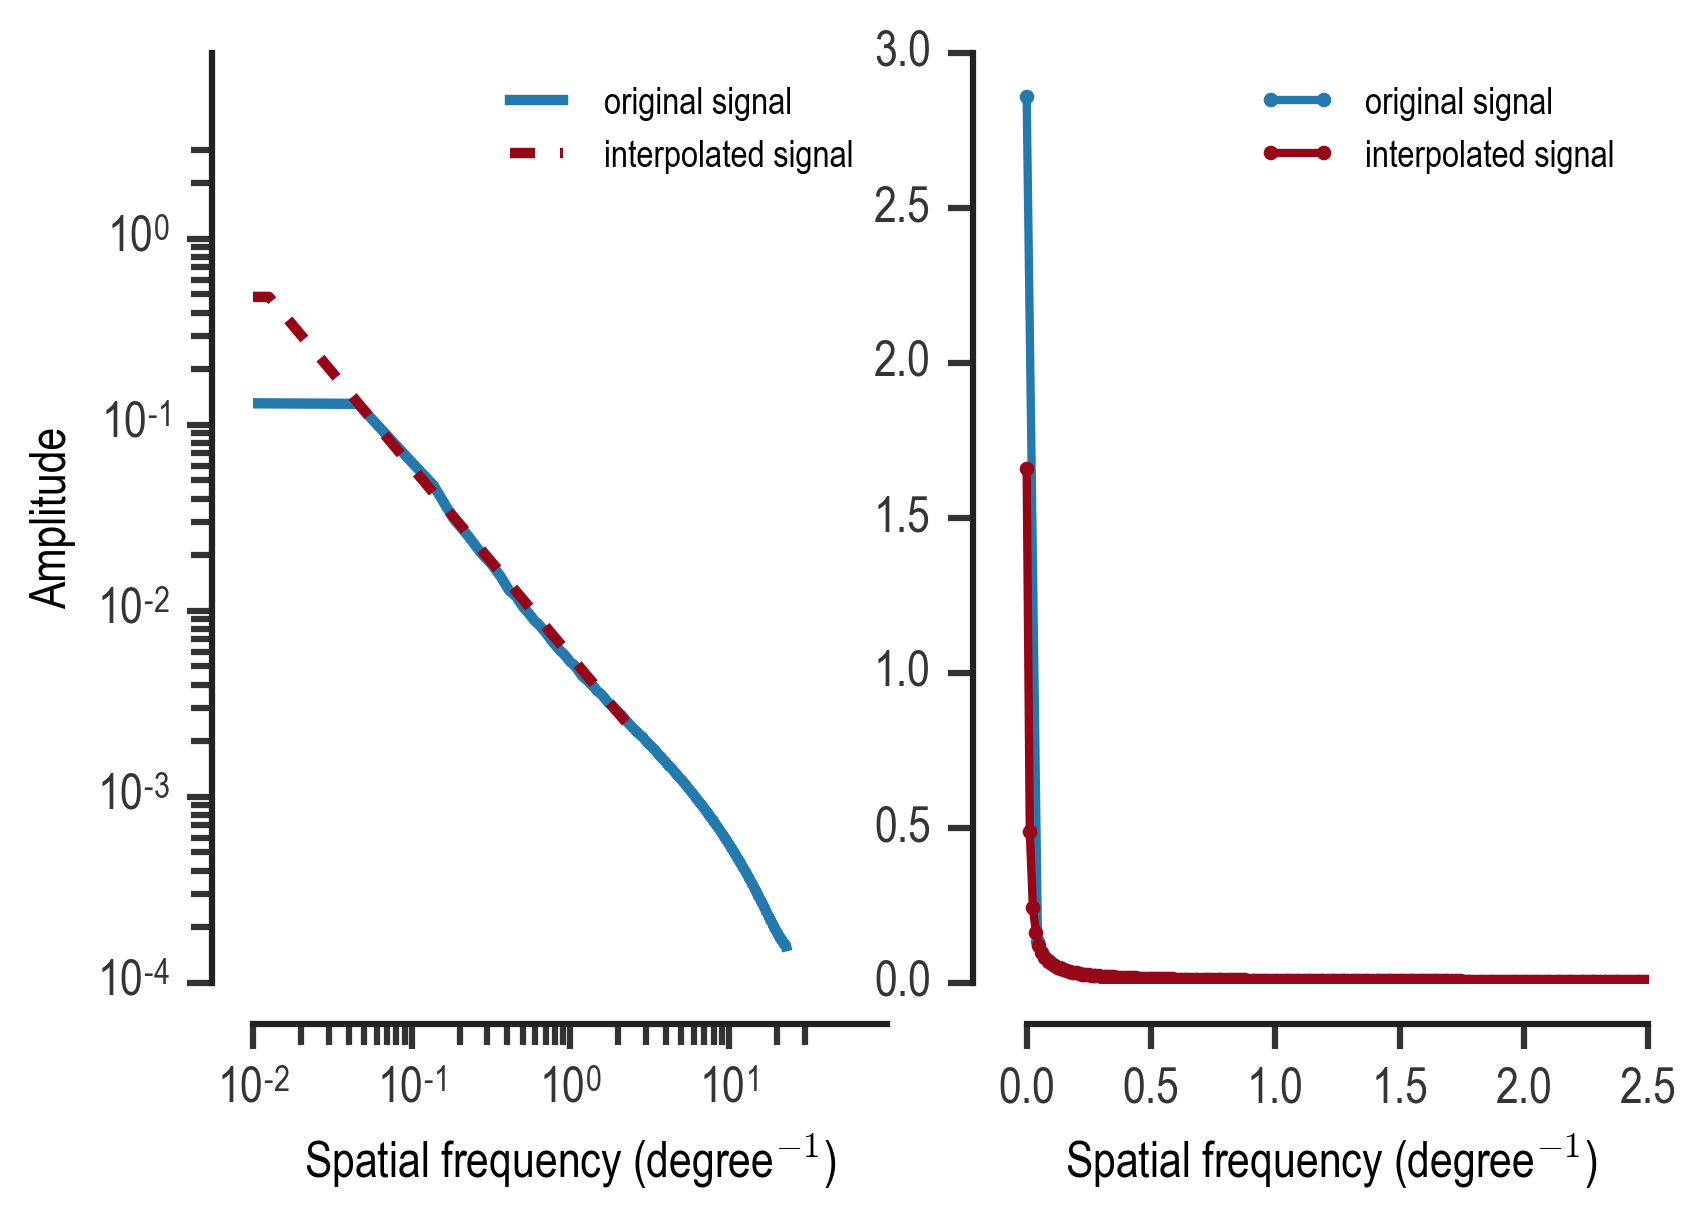

In [114]:
plt.subplot(121)
plt.plot(signal_freqs, signal_amps, label='original signal')
plt.plot(freqs, signal, '--', label='interpolated signal')
plt.legend(frameon=False, fontsize=9)
plt.xscale('log')
plt.yscale('log')
adjust_spines(plt.gca())
plt.xlabel('Spatial frequency (degree$^{-1}$)')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.plot(signal_freqs, signal_amps, '.-', markersize=6, linewidth=2, label='original signal')
plt.plot(freqs, signal, '.-', markersize=6, linewidth=2, label='interpolated signal')
adjust_spines(plt.gca())
plt.xlim(-.05, 2.5)
# plt.ylim(-.05, 1.8)
plt.xlabel('Spatial frequency (degree$^{-1}$)')
# plt.ylabel('Amplitude')
plt.legend(frameon=False, fontsize=9)

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [225]:
input_noise = 0.1
output_noise = 0.35

1.8783825368


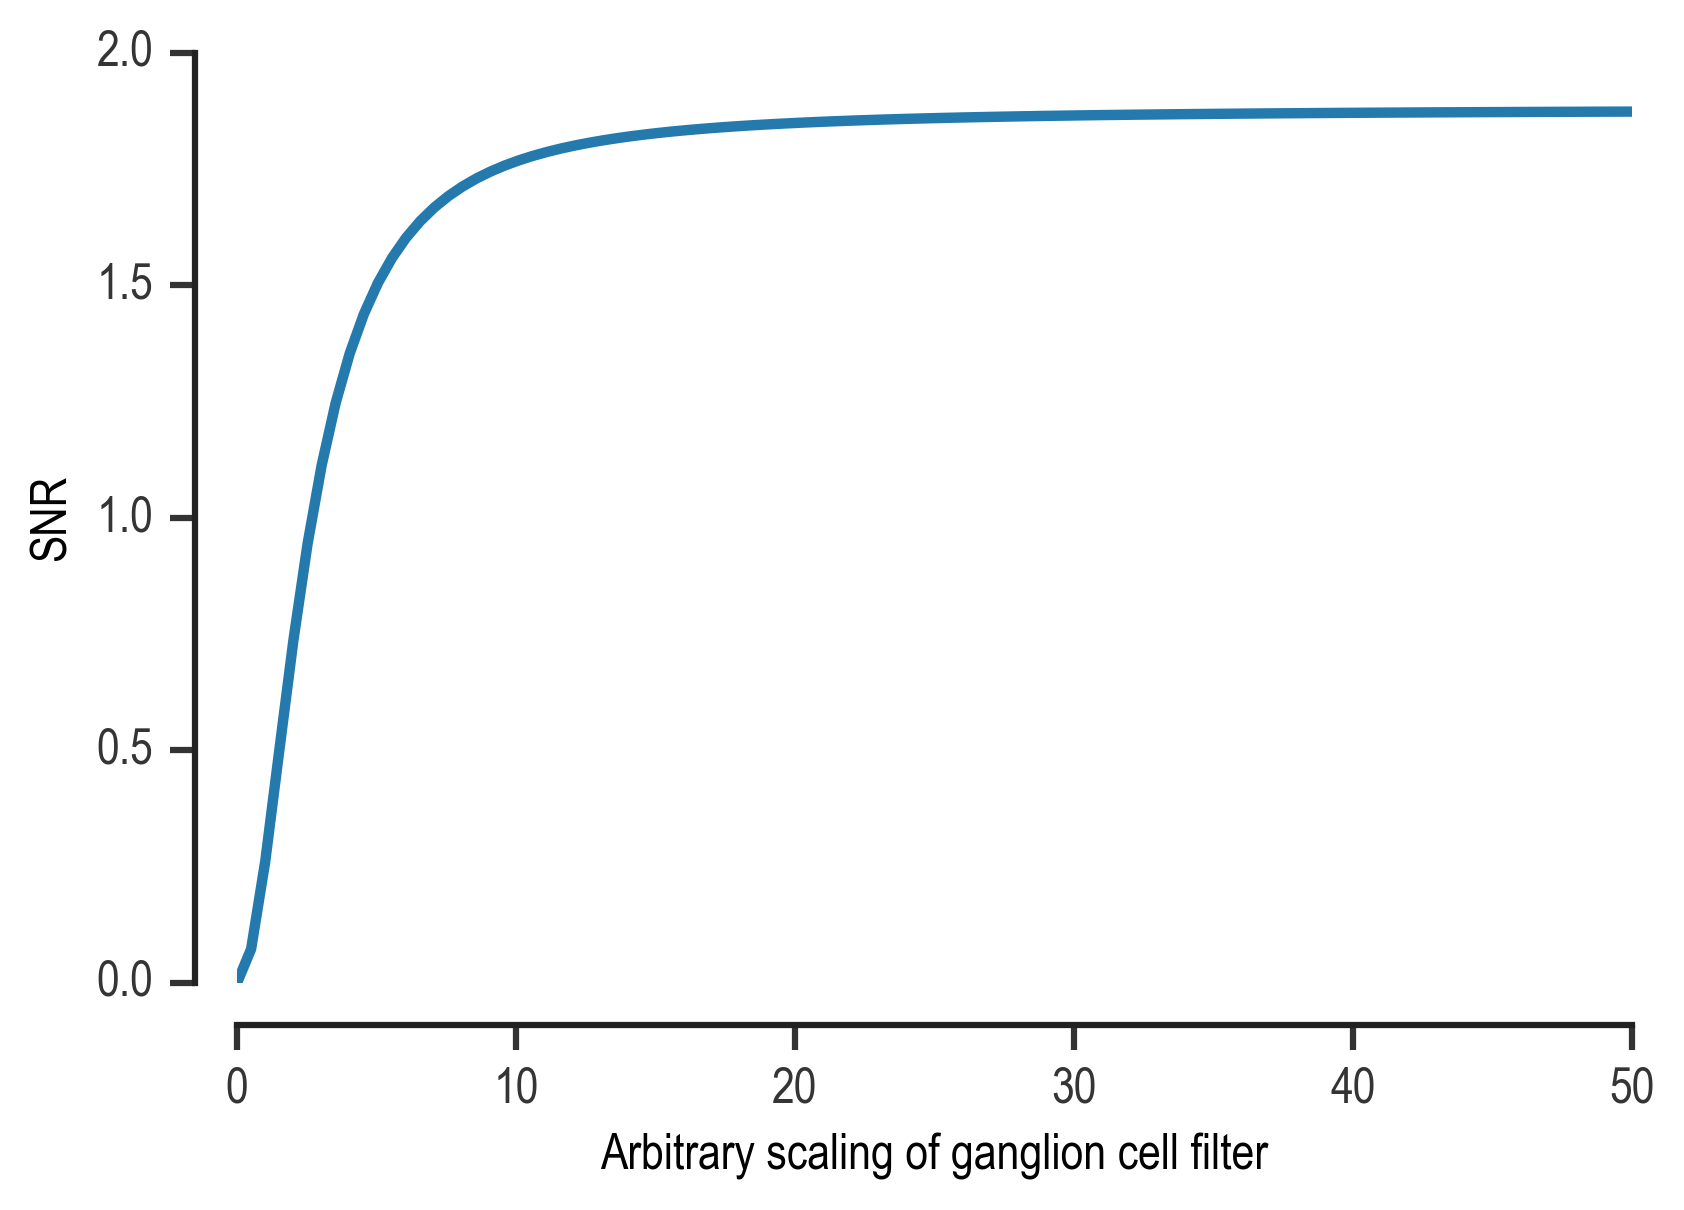

In [236]:
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

### Ideal filter

In [237]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 1.18311777571e-07.


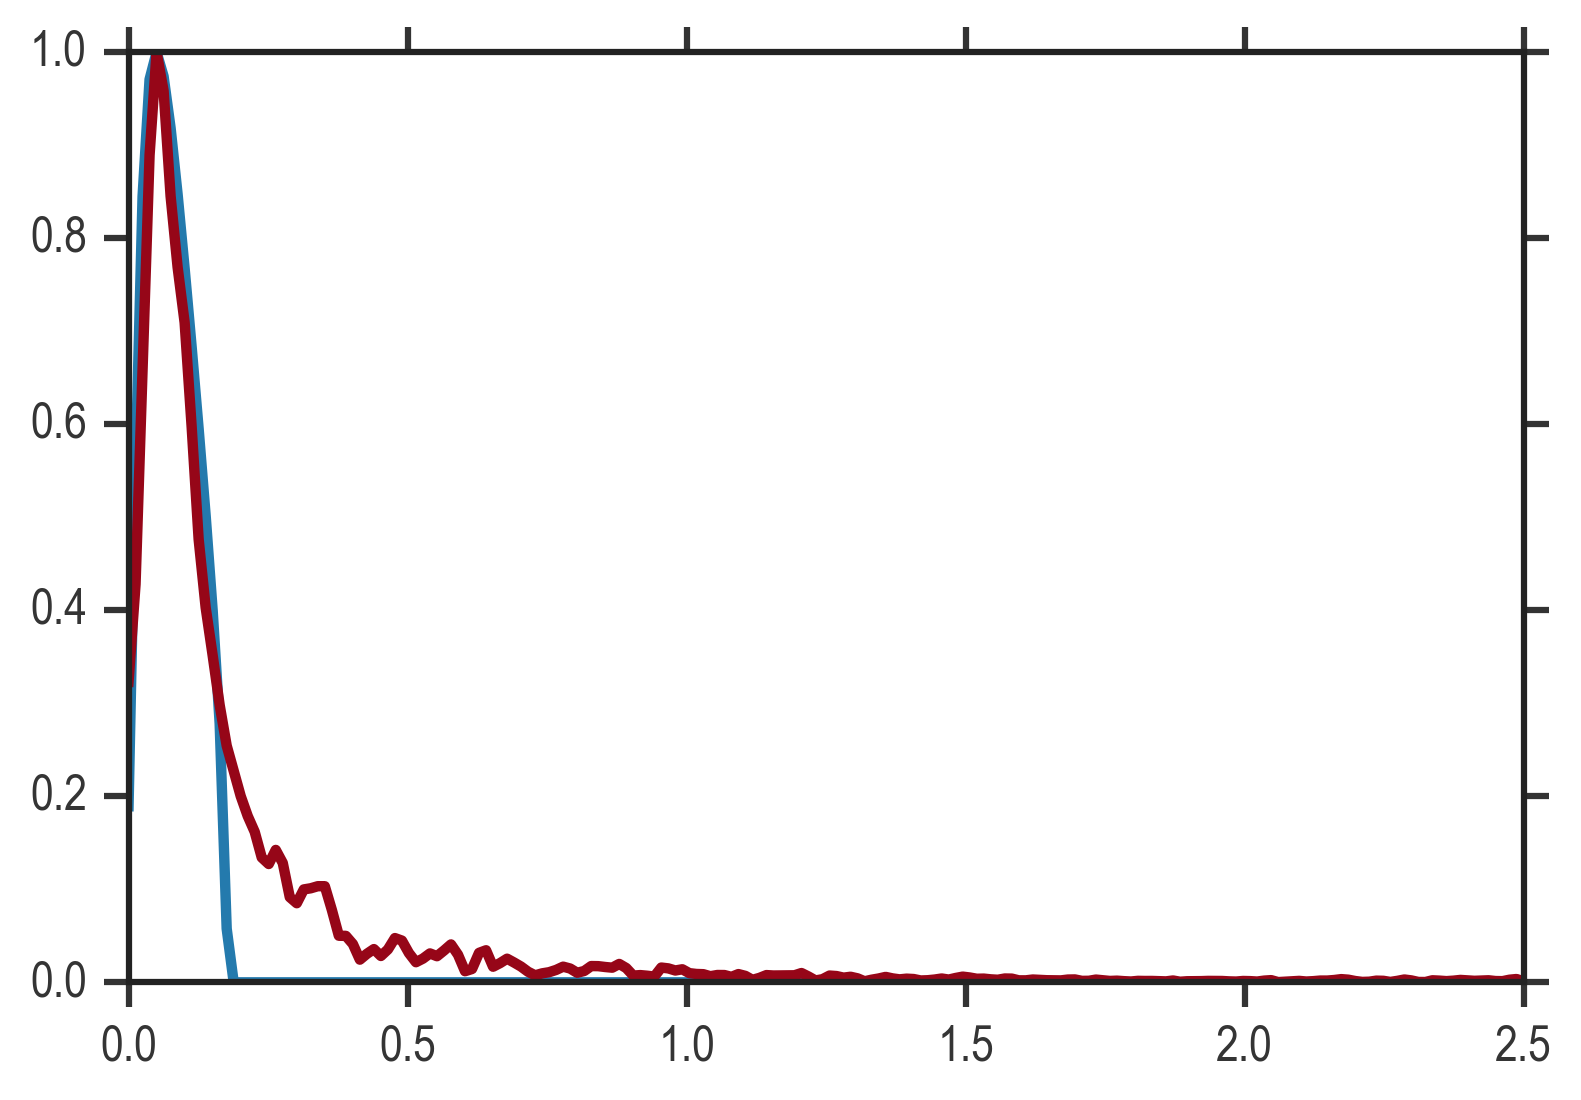

In [238]:
plt.plot(freqs, ideal_filter/np.max(ideal_filter))
plt.plot(freqs, average_ganglion_fft/np.max(average_ganglion_fft))

### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [247]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

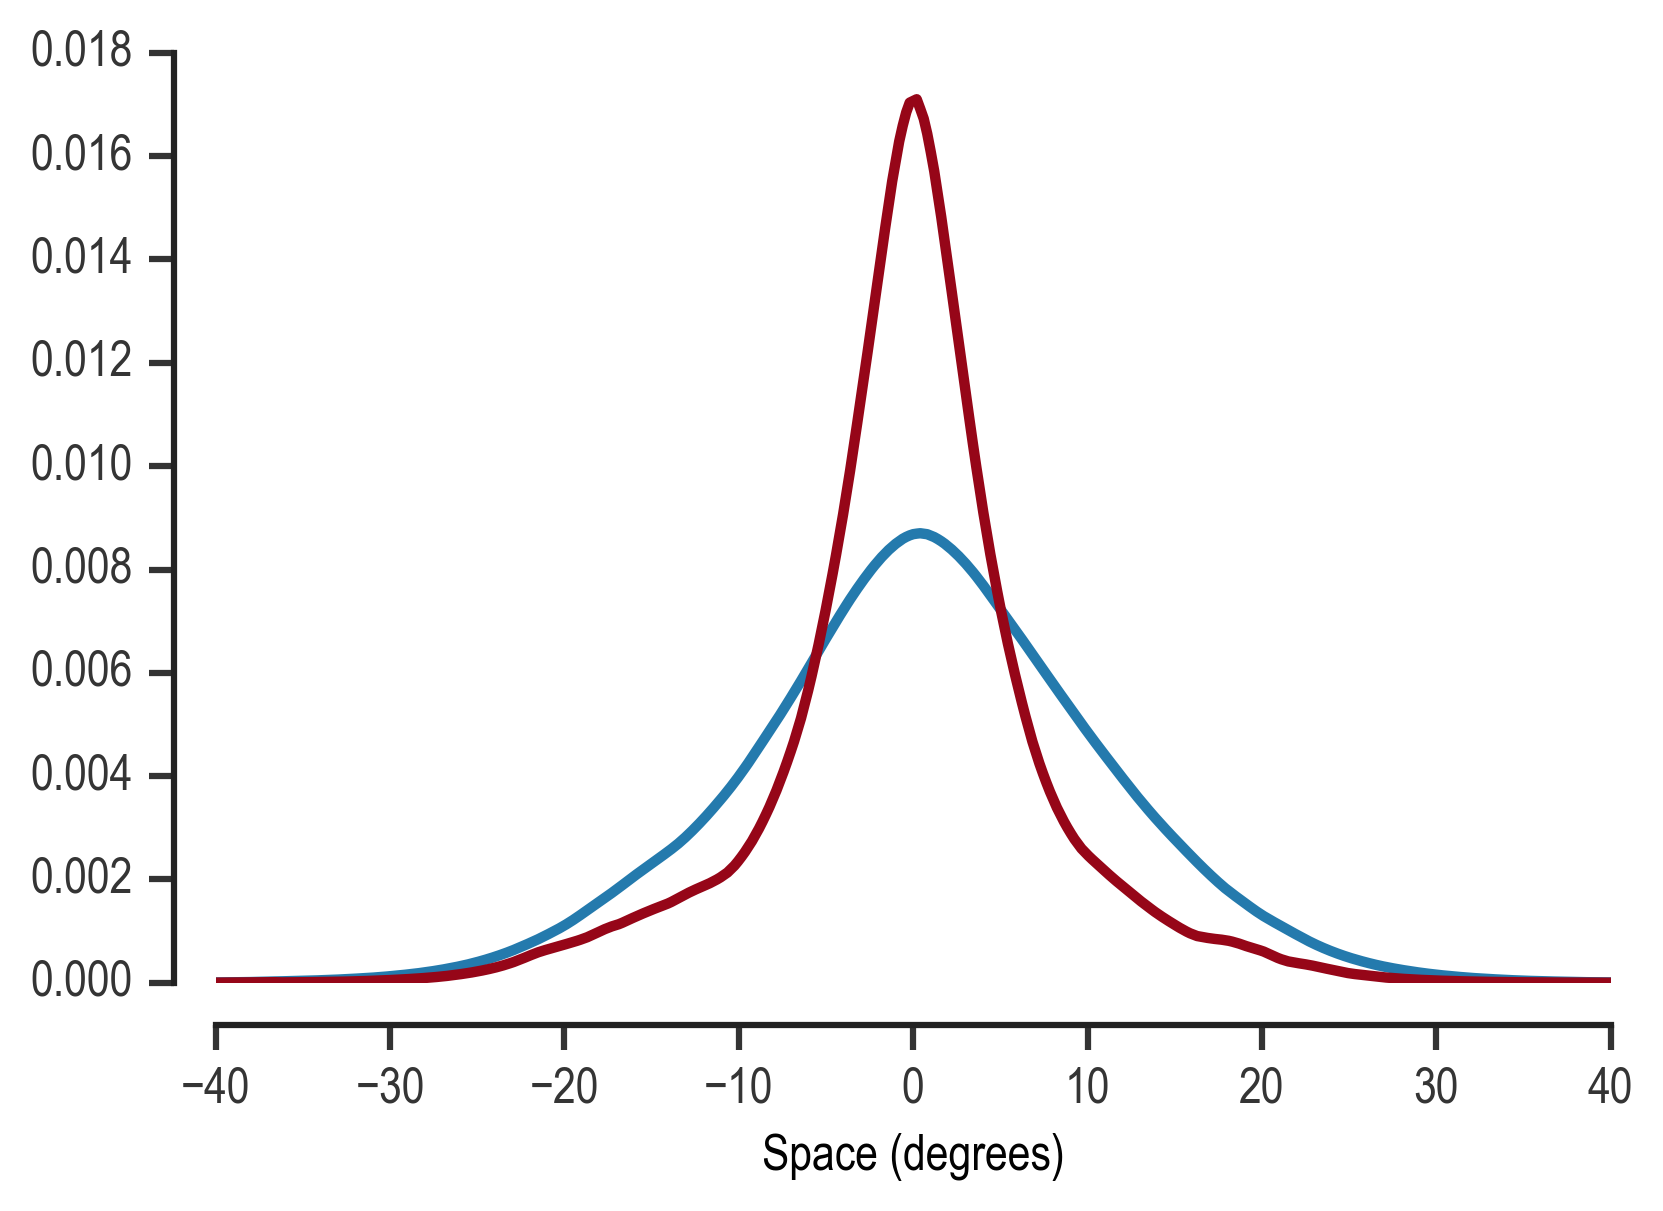

In [249]:
plt.plot(space, horz_pf)
plt.plot(space, ama_pf)
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

In [250]:
def rf_model(horz_weight, center_weight):
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)